In [41]:
import numpy as np
import matplotlib.pyplot as plt

In [58]:
trials = 1000
stddev = 300
equalization_coeffs = np.array([0.010, 0.0105])
correlation_frac = 0.1
nants = 352
test_ant_1 = 0
test_ant_2 = 1
autocorr_scaling_factor = np.zeros(trials, dtype=float)
crosscorr_scaling_factor = np.zeros(trials, dtype=float)

for trial_ind in range(trials):

    # Define random Gaussian per-antenna signals
    antenna_values = np.random.normal(
        scale=stddev, size=(nants)
    ) + 1j * np.random.normal(scale=stddev, size=(nants))
    #plt.scatter(np.real(antenna_values), np.imag(antenna_values))
    correlation_mat = np.full((nants, nants), correlation_frac, dtype=float)
    np.fill_diagonal(correlation_mat, 1)
    normalization_factor = np.sqrt(np.matmul(correlation_mat, np.conj(correlation_mat.T))[0, 0])
    correlation_mat /= normalization_factor
    antenna_values = np.matmul(correlation_mat, antenna_values)
    #plt.scatter(np.real(antenna_values), np.imag(antenna_values))
    #plt.show()

    # Apply equalization coefficients:
    antenna_values = antenna_values[:, np.newaxis] * equalization_coeffs[np.newaxis, :]

    # Quantize values to integers [-7, 7]
    antenna_values_quantized_real_part = np.round(np.real(antenna_values))
    antenna_values_quantized_real_part[
        np.where(antenna_values_quantized_real_part < -7)
    ] = -7
    antenna_values_quantized_real_part[np.where(antenna_values_quantized_real_part > 7)] = 7
    antenna_values_quantized_imag_part = np.round(np.imag(antenna_values))
    antenna_values_quantized_imag_part[
        np.where(antenna_values_quantized_imag_part < -7)
    ] = -7
    antenna_values_quantized_imag_part[np.where(antenna_values_quantized_imag_part > 7)] = 7
    antenna_values_quantized = (
        antenna_values_quantized_real_part + 1j * antenna_values_quantized_imag_part
    )

    # Calculate autocorrelations
    autocorrs_orig = antenna_values * np.conj(antenna_values)
    autocorrs_quantized = antenna_values_quantized * np.conj(antenna_values_quantized)
    #plt.plot(autocorrs_orig)
    #plt.plot(autocorrs_quantized)

    # Calculate cross correlations
    crosscorrs_orig = antenna_values[:, np.newaxis, :] * np.conj(
        antenna_values[np.newaxis, :, :]
    )
    crosscorrs_quantized = antenna_values_quantized[:, np.newaxis, :] * np.conj(
        antenna_values_quantized[np.newaxis, :, :]
    )
    # Mask autocorrelations and conjugated values
    #for ind in range(len(equalization_coeffs)):
    #    crosscorrs_orig[np.tril_indices(nants, k=0), ind] = np.nan
    #    crosscorrs_quantized[np.tril_indices(nants, k=0), ind] = np.nan

    # Calculate fractional error
    autocorr_scaling_factor[trial_ind] = (
        np.abs(autocorrs_quantized[test_ant_1, 1]) / np.abs(autocorrs_quantized[test_ant_1, 0])
    )
    print(np.abs(autocorrs_orig[test_ant_1, 1]) / np.abs(autocorrs_orig[test_ant_1, 0]))
    crosscorr_scaling_factor[trial_ind] = (
        np.abs(crosscorrs_quantized[test_ant_2, test_ant_1, 1]) / np.abs(crosscorrs_quantized[test_ant_2, test_ant_1, 0])
    )
    print(np.abs(crosscorrs_orig[test_ant_2, test_ant_1, 1]) / np.abs(crosscorrs_orig[test_ant_2, test_ant_1, 0]))

1.1025000000000005
1.1025
1.1025000000000005
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025
1.1025000000000003
1.1025
1.1025
1.1024999999999998
1.1025000000000003
1.1025
1.1025
1.1025
1.1025
1.1025
1.1024999999999998
1.1024999999999998
1.1025000000000005
1.1025
1.1025
1.1025
1.1024999999999998
1.1025
1.1024999999999998
1.1025
1.1024999999999998
1.1025000000000003
1.1025
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025
1.1024999999999998
1.1024999999999998
1.1025
1.1025000000000003
1.1025000000000003
1.1025
1.1025
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1024999999999998
1.1025000000000003
1.1025000000000003
1.1024999999999998
1.1025
1.1025
1.1025
1.1025000000000003
1.1025000000000003
1.1025
1.1025
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025
1.1025
1.1025000000000003
1.1025000000000003
1.10250000000

/tmp/ipykernel_195156/2115475825.py:64: RuntimeWarning: invalid value encountered in scalar divide
  np.abs(autocorrs_quantized[test_ant_1, 1]) / np.abs(autocorrs_quantized[test_ant_1, 0])
/tmp/ipykernel_195156/2115475825.py:68: RuntimeWarning: invalid value encountered in scalar divide
  np.abs(crosscorrs_quantized[test_ant_2, test_ant_1, 1]) / np.abs(crosscorrs_quantized[test_ant_2, test_ant_1, 0])


1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025
1.1025
1.1025000000000003
1.1025
1.1025000000000003
1.1025
1.1025000000000003
1.1025000000000003
1.1025
1.1025
1.1025000000000003
1.1025000000000003
1.1025
1.1024999999999998
1.1025
1.1024999999999998
1.1024999999999998
1.1024999999999998
1.1024999999999998
1.1025
1.1025000000000003
1.1025000000000003
1.1025
1.1024999999999998
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025
1.1025
1.1025000000000003
1.1025
1.1025
1.1025
1.1025000000000003
1.1025
1.1025
1.1025
1.1025000000000003
1.1025000000000003
1.1025000000000003
1.1025
1.1025000000000005
1.1025
1.1025
1.1025
1.1025
1.1025
1.1025000000000003
1.1025
1.1025
1.1024999999999998
1.1024999999999998
1.1025
1.1025000000000003
1.1025
1.1025000000000003
1.1025
1.1024999999999998
1.1025000000000003
1.1025000000000003
1.1024999999999998
1.1025
1.1025000000000003
1.102500000

In [44]:
crosscorr_scaling_factor

array([1.26491106, 1.        , 1.        , 1.25      , 1.30384048,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.10431526, 1.        , 1.        , 1.11803399, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.36525928,
       1.        , 1.        , 1.23669388,        nan, 1.30384048,
       1.        , 1.41421356, 1.        , 1.41421356, 1.        ,
       1.28585307, 1.08653373, 1.        , 1.41421356, 1.23669388,
       1.        , 1.        , 1.        , 1.        , 1.27475488,
       1.        , 1.2       , 1.40932853, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.26491106, 1.        , 1.23669388, 1.15044748, 1.        ,
       1.        , 1.09812675, 1.        , 1.1785113 , 1.09812675,
       1.11803399, 1.27475488, 1.13529242, 1.5       , 1.17669681,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.20415946, 1.08465229, 1.     

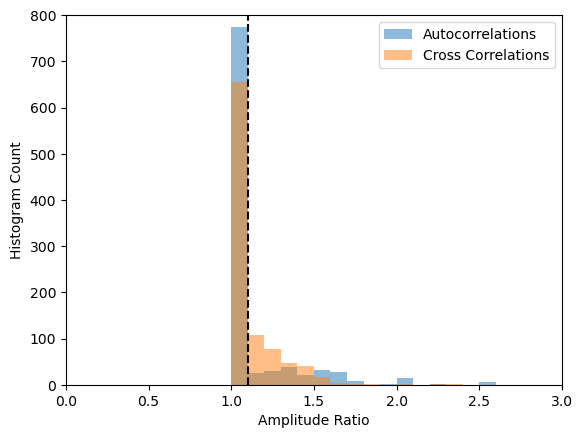

In [53]:
autocorr_scaling_factor[np.where(~np.isfinite(autocorr_scaling_factor))] = np.nan
crosscorr_scaling_factor[np.where(~np.isfinite(crosscorr_scaling_factor))] = np.nan

hist_max = 3
plt.hist(autocorr_scaling_factor, bins=30, range=(0, hist_max), alpha=.5, label="Autocorrelations")
plt.hist(
    crosscorr_scaling_factor,
    bins=30,
    range=(0, hist_max),
    alpha=0.5,
    label="Cross Correlations",
)
true_value = equalization_coeffs[1]**2 / equalization_coeffs[0]**2
plt.plot([true_value, true_value], [0, 900], "--", color="black")
plt.xlabel("Amplitude Ratio")
plt.ylabel("Histogram Count")
plt.xlim((0, hist_max))
plt.ylim((0,800))
plt.legend()

In [54]:
true_value

1.1025

In [55]:
np.nanmean(autocorr_scaling_factor)

1.107919782137115

In [56]:
np.nanmean(crosscorr_scaling_factor)

1.094574569380778

/tmp/ipykernel_195156/623945707.py:1: RuntimeWarning: divide by zero encountered in divide
  crosscorrs_ratio = crosscorrs_quantized[:, :, 1]/crosscorrs_quantized[:, :, 0]
/tmp/ipykernel_195156/623945707.py:1: RuntimeWarning: invalid value encountered in divide
  crosscorrs_ratio = crosscorrs_quantized[:, :, 1]/crosscorrs_quantized[:, :, 0]
/tmp/ipykernel_195156/623945707.py:2: RuntimeWarning: divide by zero encountered in divide
  autocorrs_ratio = autocorrs_quantized[:, 1] / autocorrs_quantized[:, 0]
/tmp/ipykernel_195156/623945707.py:2: RuntimeWarning: invalid value encountered in divide
  autocorrs_ratio = autocorrs_quantized[:, 1] / autocorrs_quantized[:, 0]


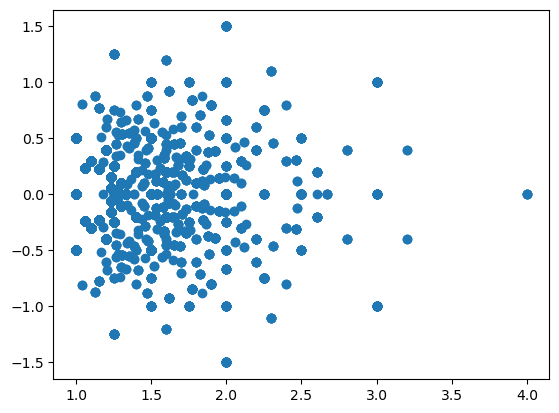

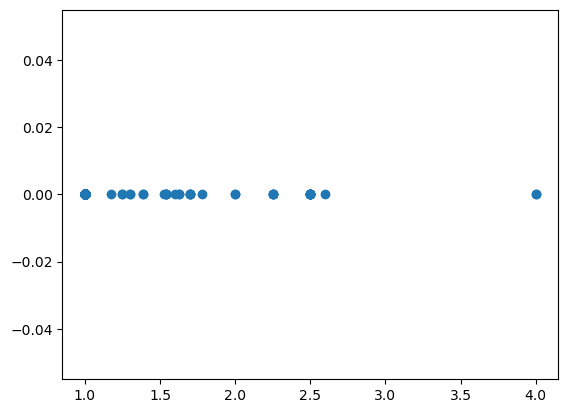

In [ ]:
crosscorrs_ratio = crosscorrs_quantized[:, :, 1]/crosscorrs_quantized[:, :, 0]
autocorrs_ratio = autocorrs_quantized[:, 1] / autocorrs_quantized[:, 0]
plt.scatter(np.real(crosscorrs_ratio.flatten()), np.imag(crosscorrs_ratio.flatten()))
plt.show()
plt.scatter(np.real(autocorrs_ratio), np.imag(autocorrs_ratio))
plt.show()

In [ ]:
crosscorrs_ratio

array([[nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       ...,
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj]])

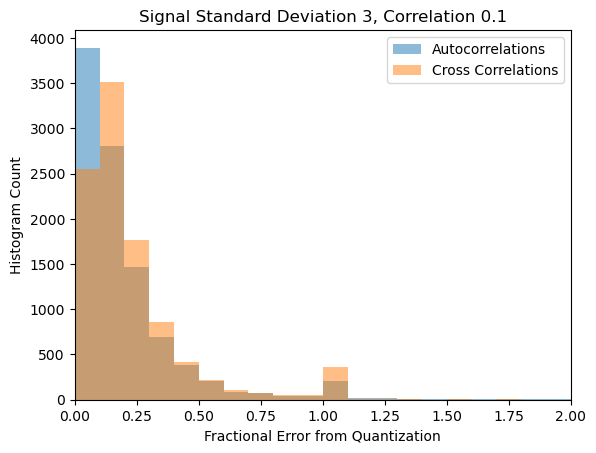

In [ ]:
# hist_max = np.max(
#    [np.nanmax(autocorr_fractional_error), np.nanmax(crosscorr_fractional_error)]
# )
hist_max = 2
plt.hist(autocorr_fractional_error, bins=20, range=(0, hist_max), alpha=.5, label="Autocorrelations")
plt.hist(
    crosscorr_fractional_error,
    bins=20,
    range=(0, hist_max),
    alpha=0.5,
    label="Cross Correlations",
)
plt.xlabel("Fractional Error from Quantization")
plt.ylabel("Histogram Count")
plt.title(f"Signal Standard Deviation {stddev}, Correlation {correlation_frac}")
plt.xlim((0, hist_max))
plt.legend()